<a href="https://colab.research.google.com/github/kmouleejunhyuk/windturbine/blob/main/windturbine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 풍력발전기 상태이상 판별 과제

In [1]:
###
#python, pytorch
#data not encluded due to copyrights issue

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import time
import random

In [3]:
#구글 드라이브 마운트 & 경로설정
from google.colab import drive
drive.mount('/gdrive')

PATH='/gdrive/My Drive/windturbine'

Mounted at /gdrive


In [4]:
#seed for reproducability
random_seed=49   #44159
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#### Data loading and EDA

In [6]:
#data import
train_raw=pd.read_csv(PATH+'/training_data_set.csv')
test_raw=pd.read_csv(PATH+'/validation_data_set.csv')

In [17]:
#EDA helper function
def EDA(df: pd.DataFrame):
    print(df.head(), '\n')
    print(df.dtypes, '\n')

    for _ in df.columns:
        if df[_].isna().sum() != 0 or df[_].dtypes != 'float64':
            #static information
            print('column '+ _ + ' static info')
            print('max:', '\t\t', df[_].max())
            print('min:', '\t\t', df[_].min())
            print('avg:', '\t\t', df[_].mean())
            print('count of na: ', '\t\t', df[_].isna().sum())
            print('unique values: ', '\t\t', df[_].nunique(dropna=False))

            #plot boxplot by column
            source=df[_].copy()
            plt.rcParams['figure.figsize']=[10, 6]
            plt.title(_)
            plt.boxplot(source, notch=1, sym='rs', vert=0)
            plt.show()
            plt.close()
            print('\n')

        #else: print('no na and float value in column {}. max: {}, min: {}, avg: {} \n'.format(_, df[_].max(), df[_].min(), df[_].mean()))

          1         2    3    4         5  ...  682  683  684  685  686
0  0.621211  0.771822  0.5  0.5  0.618948  ...    0    0    0    0    1
1  0.624648  0.319315  0.5  0.5  0.625634  ...    0    0    0    0    1
2  0.625174  0.244754  0.5  0.5  0.626474  ...    0    0    0    0    1
3  0.628112  0.266645  0.5  0.5  0.627791  ...    0    0    0    0    1
4  0.629918  0.204191  0.5  0.5  0.629838  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


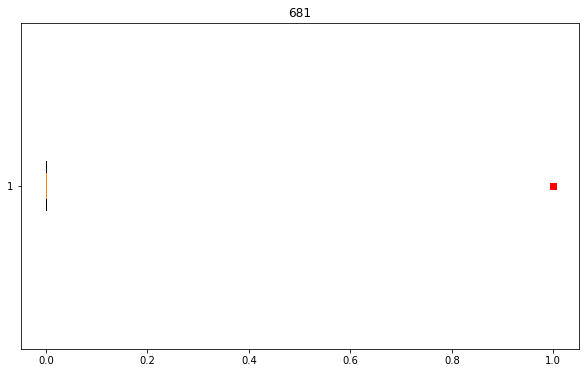



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


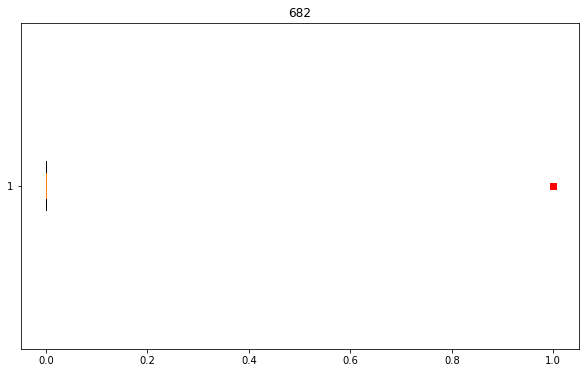



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.14625
count of na:  		 0
unique values:  		 2


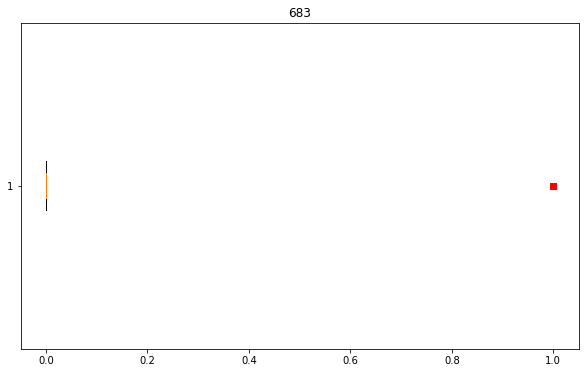



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


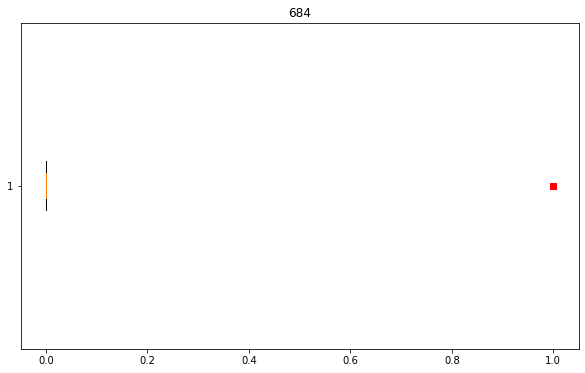



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.16375
count of na:  		 0
unique values:  		 2


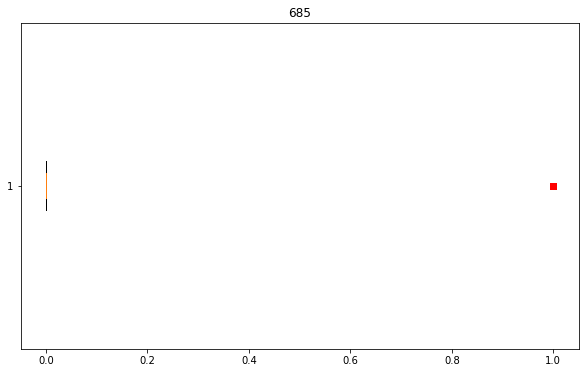



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


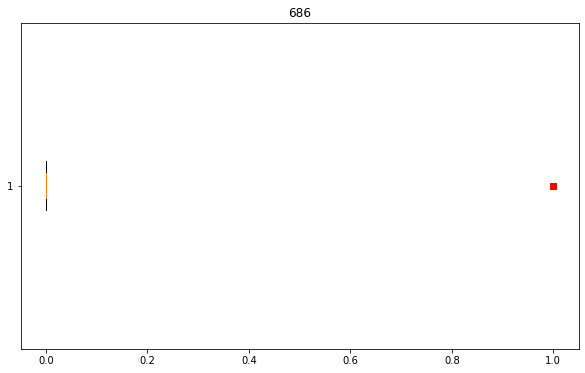

In [18]:
EDA(train_raw)

          1         2    3    4         5  ...  682  683  684  685  686
0  1.019280  1.240127  0.5  0.5  1.018462  ...    0    0    0    0    1
1  1.019262  1.248247  0.5  0.5  1.018890  ...    0    0    0    0    1
2  1.023792  1.286444  0.5  0.5  1.024392  ...    0    0    0    0    1
3  1.023431  1.364974  0.5  0.5  1.023545  ...    0    0    0    0    1
4  1.018795  1.277456  0.5  0.5  1.021053  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


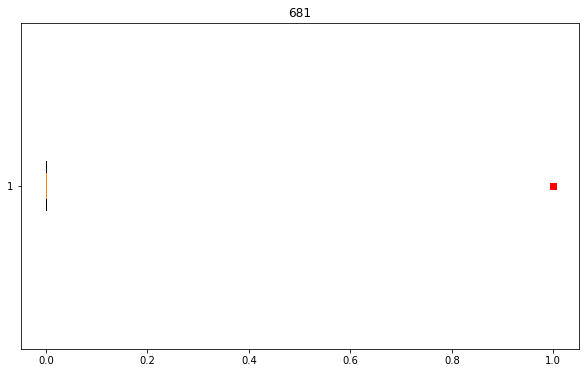



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


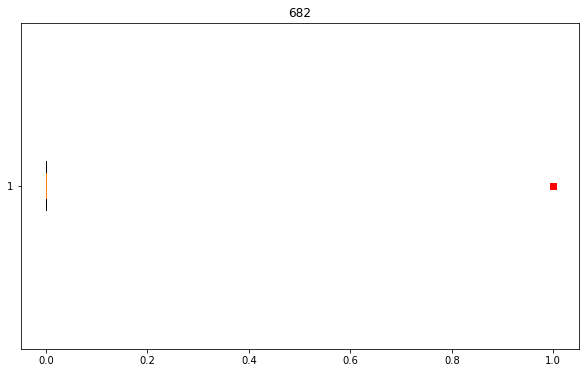



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


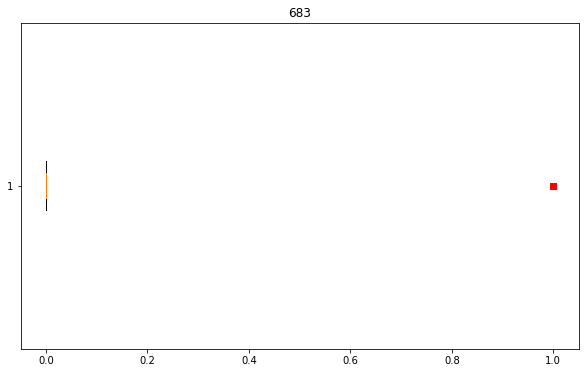



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


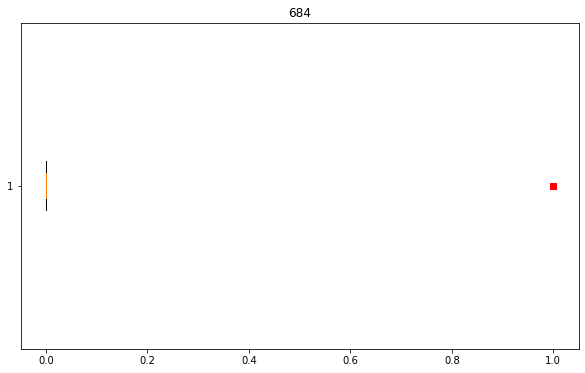



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.22
count of na:  		 0
unique values:  		 2


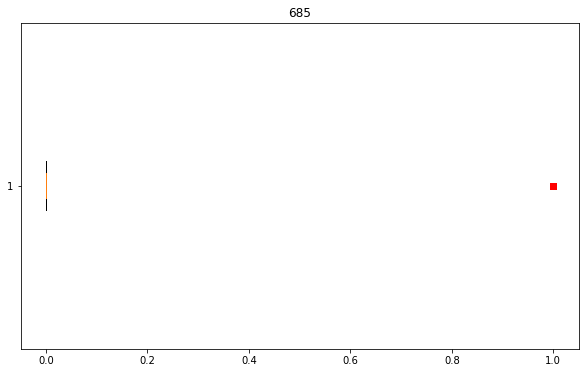



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.14
count of na:  		 0
unique values:  		 2


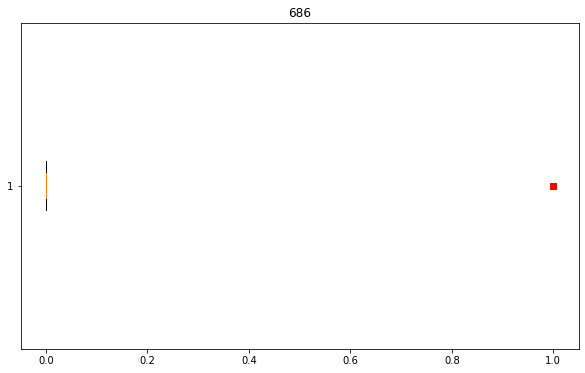

In [19]:
EDA(test_raw)

In [ ]:
##column 681~686 seems to be one-hot encoded target value